In [1]:
import slmpy
import numpy as np
import time
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import math as mt 
import matplotlib.pyplot as plt
import scipy.special as sci
from matplotlib.animation import FuncAnimation
import tqdm as tqdm
from matplotlib.colors import LinearSegmentedColormap
import time as time
from matplotlib import rc
colors = [(0, 0, 0), (1, 0, 0)] # first color is black, last is red
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=20)

cm1 = LinearSegmentedColormap.from_list(
        "Custom", [(1,0,0),(0,0,0)], N=20)



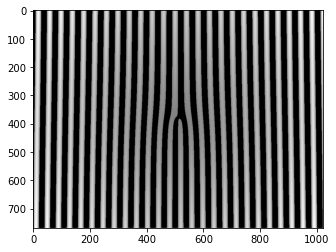

In [3]:

Nxpix = 1024
Nypix = 768


def LG(p,ell,r):
    return sci.assoc_laguerre(r,ell,p)

def ElectrischenFeld(p,ell,w,xx,yy,theta=0,total_z_prop=True):
    if not total_z_prop:
        prop = np.exp(1j*k*np.sin(theta)*XX)
    else:
        prop = 1
    rr = np.sqrt(xx**2 + yy**2)
    A = np.sqrt(2/(np.pi*mt.factorial(np.abs(ell))))
    B = (np.sqrt(2)*rr/w)**np.abs(ell)
    C = np.exp(-rr**2/w**2)
    Phase = np.exp(1j*ell*(np.arctan2(yy,xx))) 
    ElectricFeld = A*B*C*LG(2*rr**2/w**2,np.abs(ell),p)*Phase*prop
    return ElectricFeld



k = 70

w = 455/9
x = Nxpix/np.min([Nypix,Nxpix])
y = Nypix/np.min([Nypix,Nxpix])

d1 = np.linspace(-x,x,Nxpix)
d2 = np.linspace(-y,y,Nypix)

XX,YY = np.meshgrid(d1,d2)
X,Y = np.meshgrid(np.linspace(0,Nxpix,Nxpix),np.linspace(0,Nypix,Nypix))




gray="gray"
rb = "rainbow"
theta = 60
theta = np.pi*theta/180
E1 = ElectrischenFeld(0,1,w,XX,YY)
E2 = ElectrischenFeld(0,0,w,XX,YY,theta,False)

H1 = np.real((E2+E1)*np.conjugate(E2 + E1))
H1_int = ((H1 - H1.min()) * (1/(H1.max() - H1.min()) * 255)).astype('uint8')
H_bin=H1_int


for i in range(Nxpix-1):
    
    for j in range (Nypix-1):
        
    
        if H1_int[j,i]<255/2:
            H_bin[j,i]=0
        
H2 = np.round((2**8-1)*(0.5+0.5*np.sin(2*np.pi*X/50))).astype('uint8')
pattern=plt.imshow(H_bin,cmap="gray")







In [1]:

Nxpix = 1024
Nypix = 768
pix_sixe=1e-6


##GENERACION DE PATRONES AMPLITUD FASE SEGUN (E.Bolduc,2013) "Exact solution to simultaneous intensity and phase encryption with a single phase-only hologram"

def Amplitude_Phase_pattern(Desired_Field,LAMBDA,NX,NY):
    
    A=np.absolute(Desired_Field)
    PHI=np.phase(Desired_Field)
    
    
    
    M=A/np.max(A)
    F=PHI-np.pi*A
    
    
    psi=np.zeros(NX,NY)
    
    for m in range(NX):
        for n in range(NY):
            
            psi[i,j]=M[i,j]*np.mod(F[m,n]+2*np.pi*m/LAMBDA,2*np.pi)
         
    
    
    psi_int=((psi - psi.min()) * (1/(psi.max() - psi.min()) * 255)).astype('uint8')
    
    return  psi



H_3=Amplitude_Phase_pattern(Desired_Field,Nx,NX,NY)


In [ ]:



monitorid = 0 ## PANTALLA DONDE ESTA SLM (0 es pantalla de pc)
slm = slmpy.SLMdisplay(monitor = monitorid)
resX, resY = slm.getSize()





slm.updateArray(H1_int)



s = input()


if s=="c":
    
    slm.close()







SystemError: <class 'wx._core.PaintEvent'> returned a result with an error set

SystemError: <class 'wx._core.PaintEvent'> returned a result with an error set

Exception in thread Thread-9:
Traceback (most recent call last):
  File "C:\Users\THINKBOOK\anaconda3\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "C:\Users\THINKBOOK\Documents\Libros uni\Proyecto\CODIGOS\slmpy.py", line 434, in run
    app.MainLoop()
  File "C:\Users\THINKBOOK\anaconda3\lib\site-packages\wx\core.py", line 2262, in MainLoop
    rv = wx.PyApp.MainLoop(self)
wx._core.wxAssertionError: C++ assertion "wxThread::IsMain()" failed at ..\..\src\msw\evtloop.cpp(176) in wxGUIEventLoop::Dispatch(): only the main thread can process Windows messages


In [ ]:
pattern=plt.imshow(H,cmap="gray")

In [ ]:
np.shape(H1)

In [ ]:
np.max(H2)

In [ ]:
np.min(H1_int)

In [ ]:
np.shape(H1_int)[1]